# The Great Space Race to Save the Earth
#### A Near Earth Object Classification project by Brandon Navarrete

In [1]:
# clean data
import pandas as pd
import numpy as np
import os
import math

# py.files
import wrangle as wr
import model as mo

# visuals
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# stats
import scipy.stats as stats
import statistics
import sklearn.preprocessing
from scipy.stats import mannwhitneyu
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



# nuissance imports
import warnings
warnings.filterwarnings("ignore")



# Acquire

<div class="alert alert-block alert-info">
<b>Acquire:</b> 
    
* This data was pulled from kaggle(2023) which was queried using NASA's api (https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects)

* 90836 rows, each it's own object or asteroids with 10 columns of its features

In [2]:
# grabs data and prints shape
df = wr.get_data()

(90836, 10)


# Prepare

<div class="alert alert-block alert-info">
<b>Acquire:</b> 
    
* `id`,`name`, `orbiting_body`,`sentry_object` where all dropped due to not being helpful, repeating information
* target variable one-hot encoded for m.l
* the outliers were left in
* nulls not present


In [3]:
df = wr.clean_nasa(df)

# Explore

<div class="alert alert-block alert-info">
<b>Explore:</b> 
    
* How many objects are inert?
* Will diameter have a role in hazard status?
* Will absolute magnitude have a role in hazard status?



# Split

In [4]:
train,validate,test = wr.split_data(df,'hazardous')

(50867, 6) (18168, 6) (21801, 6)


## How Many of our Objects Are Inert?
### 10% of Data is Hazardous

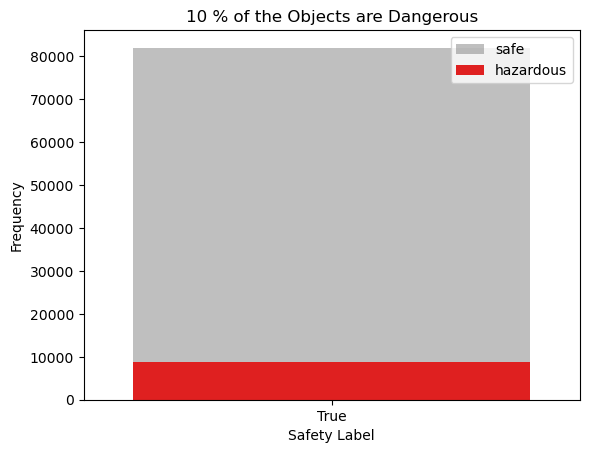

In [5]:
mo.how_many(df)

## Will Diameter play a Big Difference in Determining Hazard Status

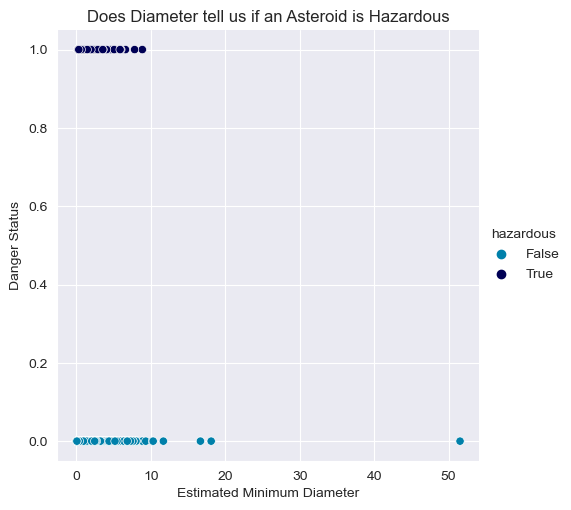

In [6]:
mo.plt_diam(train)

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
$Ho$ : Mean of `est_diameter_min` of astroids that are hazardous = Mean of `est_diameter_min` of that are NOT hazardous

$Ha$ : Mean of `est_diameter_min` of astroids that are hazardous =! Mean of `est_diameter_min` of that are NOT hazardous

In [7]:
mo.diam_stats(train)

Statistics=196359710.50, p=0.00
Reject Null Hypothesis (Significant difference between two samples)


<div class="alert alert-block alert-success">
<b>Take Aways:</b>  
* Splitting the groups into `safe` and `not safe` groups, you can see that the there is a significant difference in the mean minimum diameter meaning this may have some influence in our model


# Will Relative Velocity play a Big Difference in Determining Hazard Status

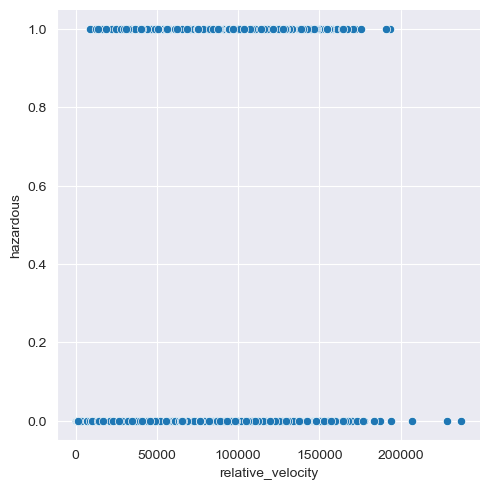

In [8]:
sns.relplot(data = train, x = 'relative_velocity',y = 'hazardous')

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
$Ho$ : Mean of `relative_velocity` of astroids that are hazardous = Mean of `relative_velocity` of that are NOT hazardous

$Ha$ : Mean of `relative_velocity` of astroids that are hazardous =! Mean of `relative_velocity` of that are NOT hazardous

In [9]:
mo.relv_stats(train)

Statistics=153652162.00, p=0.00
Reject Null Hypothesis (Significant difference between two samples)


<div class="alert alert-block alert-success">
<b>Take Aways:</b> 
    
* splitting the groups into `safe` and `not safe` objects, you can see that the there is a significant mean difference in the absolute magnitude, meaning this may have some influence in our model

* the velocity of an object plays a roll into categorizing it as safe or not


## Will Absolute Magnitude play a Big Difference in Determining Hazard Status

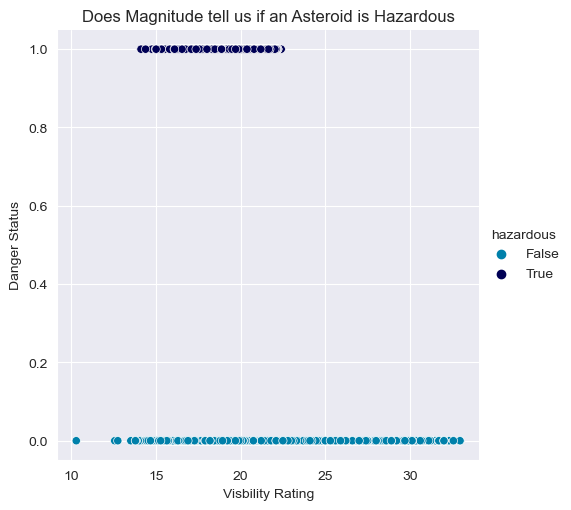

In [10]:
mo.plt_mag(train)

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
$Ho$ : Mean of `est_diameter_min` of astroids that are hazardous = Mean of `est_diameter_min` of that are NOT hazardous

$Ha$ : Mean of `est_diameter_min` of astroids that are hazardous =! Mean of `est_diameter_min` of that are NOT hazardous

In [11]:
mo.mag_stats(train)

Statistics=30929439.50, p=0.00
Reject Null Hypothesis (Significant difference between two samples)



<div class="alert alert-block alert-success">
<b>Take Aways:</b>  
    
* splitting the groups into `safe` and `not safe` objects, you can see that the there is a significant mean difference in the absolute magnitude, meaning this may have some influence in our model

* the visbility of an object plays a roll into categorizing it as safe or not


# Modeling

<div class="alert alert-block alert-info">
<b>Modeling:</b> 
    
* Recall is the evaluation metric.(I am okay with having false positives )
if it means I can find what truly matters.


In [12]:
# split x and y for modeling
x_train,y_train,x_validate,y_validate,x_test, y_test = wr.x_and_y(train,validate,test,'hazardous')

## Baseline

In [13]:
y_train,y_validate,evals, baseline_preds = mo.baseline(y_train,y_validate,'hazardous')

Baseline Accuracy: 0.90
Baseline Recall: 0.00


<div class="alert alert-block alert-danger">
<b>Modeling:</b> 
    
* Baseline recall is .10%

## Models

#### Decision Tree

In [14]:
evals = mo.add_dt_test(x_train, y_train, x_test, y_test, 20,evals)

#### KNN

In [15]:
evals = mo.add_knn_test(x_train, y_train, x_validate, y_validate, x_test,y_test,evals)

### XGBOOST!

In [16]:
evals,clf_xgb,preds = mo.add_xgboost(x_train, y_train, x_validate, y_validate, x_test,y_test,evals)

In [17]:
evals

,Recall,model
0,0.000000,baseline
1,0.305995,decision tree
2,0.029412,knn
3,0.988122,XGBOOST


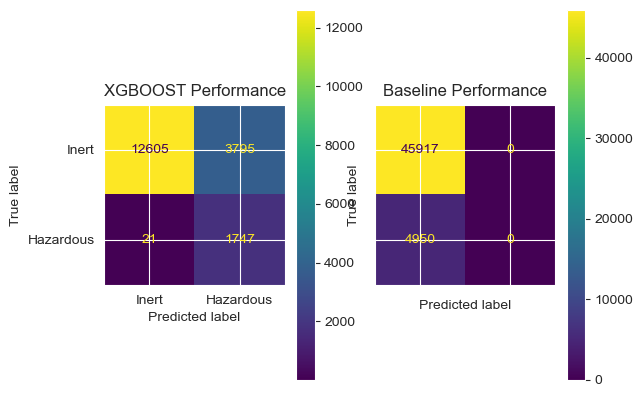

In [18]:
# model perform
mo.plot_conf(y_test,preds,y_train, baseline_preds)

# Model Wrap

<div class="alert alert-block alert-info">
<b>Model Wrap:<m/b> 
    
* XGBOOST, with given parameters, out performs recall by almost 90%
* XGBOOST detected `98%` of all `Hazardous` objects, at the cost of all those false positives

# Conclusion

<div class="alert alert-block alert-info">
<b>Conclusion:</b> 
    
* Using the features of `diameter`, `magnitude`,and `velocity` we found we were able to find what determines a hazardous object.
* We weren't necesarily able to determine what makes a safe asteriod, considering the false positives but! That's a nuiassances i'm willing to accept.

# Recommendations

<div class="alert alert-block alert-success">
<b>Recommendations:</b> 
    
* This model is operationally able to determine which astroides have a high risk, we should use it until we develop a better model.
* I would like to combine this model with image recogintion with tracking features. If we had a combo of these technologies, we would have eyes towards the sky 24/7.

# Next Steps

<div class="alert alert-block alert-info">
<b>Next Steps:</b> 

* Using the API Key, gather more information from NASA. 
* Learn image recognition.
* Apply these and try to recieve a better response.